# Tarefa A(Regressão)

Para predição de faturamento é feita uma exploração de modelos de regressão

In [1]:
import pandas as pd
rj_df=pd.read_csv('/content/Dados/rj_df.csv')
sp_df=pd.read_csv('/content/Dados/sp_df.csv')
rj_df.shape,sp_df.shape

((160, 24), (293, 24))

In [2]:
train_x=rj_df
train_x['rendaMedia']=pd.to_numeric(train_x["rendaMedia"])

train_y=train_x['faturamento'].values
train_x=train_x.drop(columns=['codigo','cidade','estado','potencial','faturamento'])
train_x.shape

(160, 19)

In [3]:
test_x=sp_df
test_x['rendaMedia']=pd.to_numeric(test_x["rendaMedia"])

test_y=test_x['faturamento'].values
test_x=test_x.drop(columns=['codigo','cidade','estado','potencial','faturamento'])
test_x.shape

(293, 19)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    train_x,train_y, test_size=0.15, random_state=42)

In [5]:
nomes = X_test['nome'].values
nomes_test = test_x['nome'].values
X_train= X_train.drop(columns=['nome'])
X_test= X_test.drop(columns=['nome'])
test_x= test_x.drop(columns=['nome'])
len(nomes),len(X_test)

(24, 24)

## Busca por regressores

In [6]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from xgboost.sklearn import XGBRegressor

In [7]:
names = [
    "ElasticNet",
    "SGDRegressor",
    "SVM",
    "BayesianRidge",
    "KernelRidge",
    "LinearRegression",
    "XGBoost"
]

classifiers = [
    ElasticNet(),
    SGDRegressor(),
    SVR(),
    BayesianRidge(),
    KernelRidge(),
    LinearRegression(),
    XGBRegressor(),
]

In [8]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


result_dict={'nome':[],'mse':[],'mae':[],'rmse':[]}

#Iterar sob classificadores
for name, clf in zip(names, classifiers):
    print(name)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    mse=mean_squared_error(y_test, y_pred)
    mae=mean_absolute_error(y_test, y_pred)
    rmse=mean_squared_error(y_test, y_pred,squared=False)
    result_dict['nome'].append(name)
    result_dict['mse'].append(mse)
    result_dict['mae'].append(mae)
    result_dict['rmse'].append(rmse)
    
result_csv=pd.DataFrame().from_dict(result_dict)
result_csv

ElasticNet
SGDRegressor
SVM
BayesianRidge
KernelRidge
LinearRegression
XGBoost
[23:22:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.968e+11, tolerance: 2.174e+09
  model = cd_fast.enet_coordinate_descent(


,nome,mse,mae,rmse
0,ElasticNet,7.828314e+10,1.226628e+05,2.797912e+05
1,SGDRegressor,3.360030e+36,1.309895e+18,1.833038e+18
2,SVM,3.780525e+11,3.408047e+05,6.148598e+05
3,BayesianRidge,5.439419e+10,1.139763e+05,2.332256e+05
4,KernelRidge,2.177491e+11,4.087115e+05,4.666359e+05
5,LinearRegression,8.267035e+10,1.291355e+05,2.875245e+05
6,XGBoost,2.991091e+10,1.034727e+05,1.729477e+05


### Xgboost(Melhor Modelo)

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import (precision_score, recall_score, f1_score,
    roc_auc_score)

pipe = Pipeline(
    steps=[
        ("XGB", XGBRegressor())
    ]
)

parameters = {
    "XGB__objective": ["reg:squarederror"],
    "XGB__learning_rate": [0.1,0.01],
    "XGB__booster": ["gbtree","gblinear"],
    "XGB__max_depth": [1,3,5,7,10],
    "XGB__min_child_weight": [1,3,5,7],
    "XGB__colsample_bytree": [0.25,0.5,0.7],
    "XGB__n_estimators": [30,50,100],
    "XGB__reg_alpha": [0.2,0.5],
    "XGB__reg_lambda": [2,5,7],
    "XGB__gamma": [3,5,7],
    "XGB__random_state": [123],

}

In [10]:
len(X_train),len(y_train)

(136, 136)

In [11]:
%%capture
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

pipe.fit(X_train, y_train)
search = GridSearchCV(pipe, parameters, cv=3, n_jobs=-1, verbose=1)
search.fit(X_train, y_train)

In [12]:
print("XGBoost\n")
print("Best parameter (CV score=%0.3f): {}\n".format(search.best_score_))
print(search.best_params_)

print("Best parameters: " + str(search.best_params_))

y_pred = search.best_estimator_.predict(X_train)
mse=mean_squared_error(y_train, y_pred)
mae=mean_absolute_error(y_train, y_pred)
rmse=mean_squared_error(y_train, y_pred,squared=False)

print('mse:',mse,'mae:',mae,'rmse:',rmse)

y_pred = search.best_estimator_.predict(X_test)
mse=mean_squared_error(y_test, y_pred)
mae=mean_absolute_error(y_test, y_pred)
rmse=mean_squared_error(y_test, y_pred,squared=False)
    
print('mse:',mse,'mae:',mae,'rmse:',rmse)

XGBoost

Best parameter (CV score=%0.3f): 0.8965888669325172

{'XGB__booster': 'gbtree', 'XGB__colsample_bytree': 0.5, 'XGB__gamma': 3, 'XGB__learning_rate': 0.1, 'XGB__max_depth': 10, 'XGB__min_child_weight': 3, 'XGB__n_estimators': 100, 'XGB__objective': 'reg:squarederror', 'XGB__random_state': 123, 'XGB__reg_alpha': 0.2, 'XGB__reg_lambda': 2}
Best parameters: {'XGB__booster': 'gbtree', 'XGB__colsample_bytree': 0.5, 'XGB__gamma': 3, 'XGB__learning_rate': 0.1, 'XGB__max_depth': 10, 'XGB__min_child_weight': 3, 'XGB__n_estimators': 100, 'XGB__objective': 'reg:squarederror', 'XGB__random_state': 123, 'XGB__reg_alpha': 0.2, 'XGB__reg_lambda': 2}
mse: 231062465.77866277 mae: 4561.462129480698 rmse: 15200.738987913146
mse: 30920963716.383953 mae: 89811.61197916667 rmse: 175843.57741010602


In [13]:
#retreinar com os melhores parâmetros
model=XGBRegressor(booster= 'gbtree', colsample_bytree= 0.25,
                   gamma= 3, learning_rate= 0.1, max_depth= 7,
                   min_child_weight= 3, n_estimators= 100, 
                   objective= 'reg:squarederror', random_state= 123, 
                   reg_alpha= 0.2, reg_lambda= 5)
model.fit(X_train,y_train)

XGBRegressor(colsample_bytree=0.25, gamma=3, max_depth=7, min_child_weight=3,
             objective='reg:squarederror', random_state=123, reg_alpha=0.2,
             reg_lambda=5)

In [14]:
y_pred = model.predict(X_test)

In [15]:
results_reg={'nome':[],'real':[],'predicao':[]}
for i in range(len(X_test)):
  results_reg['nome'].append(nomes[i])
  results_reg['real'].append(y_test[i])
  results_reg['predicao'].append(y_pred[i])
results_reg=pd.DataFrame().from_dict(results_reg)
results_reg

,nome,real,predicao
0,Pedra De Guaratiba,832018.0,8.012392e+05
1,Piedade,808082.0,8.422248e+05
2,Tijuca,2157079.0,1.534679e+06
3,Gardênia Azul,641865.0,7.316982e+05
4,Moneró,978197.0,9.236309e+05
5,Cidade De Deus,488021.0,5.620263e+05
6,Parque Anchieta,744303.0,8.037671e+05
7,Freguesia (Ilha Do Governador),796321.0,8.416055e+05
8,Parada De Lucas,630075.0,6.835660e+05
9,Todos Os Santos,1200769.0,1.151904e+06


In [16]:
mse=mean_squared_error(y_test, y_pred)
mae=mean_absolute_error(y_test, y_pred)
rmse=mean_squared_error(y_test, y_pred,squared=False)

print('mse:',mse,'mae:',mae,'rmse:',rmse)

mse: 61133322316.58545 mae: 122722.70572916667 rmse: 247251.53653028214


In [17]:
y_pred = model.predict(test_x)

In [18]:
len(nomes_test),len(y_pred),len(test_x)

(293, 293, 293)

In [19]:
results_reg={'nome':[],'predicao':[]}
for i in range(len(test_x)):
  results_reg['nome'].append(nomes_test[i])
  results_reg['predicao'].append(y_pred[i])
results_reg=pd.DataFrame().from_dict(results_reg)
results_reg

,nome,predicao
0,A. E. Carvalho,1.918710e+05
1,Aclimação,1.461736e+06
2,Adventista,1.755095e+05
3,Água Branca,1.263479e+06
4,Água Funda,7.564638e+05
...,...,...
288,Vila Sônia,1.326893e+06
289,Vila Suzana,1.415335e+06
290,Vila Terezinha,9.153688e+04
291,Vila Zatt,2.837984e+05


# Tarefa C(classificacao)

In [20]:
import pandas as pd
rj_df=pd.read_csv('/content/Dados/rj_df.csv')
sp_df=pd.read_csv('/content/Dados/sp_df.csv')
rj_df.shape,sp_df.shape

((160, 24), (293, 24))

In [21]:
#imports
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)

In [22]:
test_x=sp_df
test_x['rendaMedia']=pd.to_numeric(test_x["rendaMedia"])
test_x=test_x.drop(columns=['codigo','nome','cidade','estado','potencial','faturamento'])

test_x.shape

(293, 18)

In [23]:
train_x=rj_df
train_x['rendaMedia']=pd.to_numeric(train_x["rendaMedia"])
train_y=train_x['potencial'].values
train_x=train_x.drop(columns=['codigo','nome','cidade','estado','potencial','faturamento'])
train_x.shape

(160, 18)

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    train_x,train_y, test_size=0.30, random_state=42)

## Busca de Classificadores

In [25]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier

names = [
    "Nearest Neighbors",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
    "XGBoost"
]

classifiers = [
    KNeighborsClassifier(3),
    # SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    XGBClassifier()
]

In [26]:
from sklearn.metrics import classification_report
result_dict={'model':[],'precision':[],'recall':[],'f1-score':[]}

#Iterar sob classificadores
for name, clf in zip(names, classifiers):
    print(name)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    cr=classification_report(y_test, y_pred,output_dict=True)
    print(cr)
    result_dict['model'].append(name)
    result_dict['precision'].append(cr['weighted avg']['precision'])
    result_dict['recall'].append(cr['weighted avg']['recall'])
    result_dict['f1-score'].append(cr['weighted avg']['f1-score'])

    
result_csv=pd.DataFrame().from_dict(result_dict)
result_csv

Nearest Neighbors
{'Alto': {'precision': 0.7619047619047619, 'recall': 1.0, 'f1-score': 0.8648648648648648, 'support': 16}, 'Baixo': {'precision': 0.8, 'recall': 0.9411764705882353, 'f1-score': 0.8648648648648648, 'support': 17}, 'Médio': {'precision': 0.8571428571428571, 'recall': 0.4, 'f1-score': 0.5454545454545455, 'support': 15}, 'accuracy': 0.7916666666666666, 'macro avg': {'precision': 0.8063492063492063, 'recall': 0.7803921568627451, 'f1-score': 0.7583947583947585, 'support': 48}, 'weighted avg': {'precision': 0.8051587301587301, 'recall': 0.7916666666666666, 'f1-score': 0.76504914004914, 'support': 48}}
RBF SVM
{'Alto': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 16}, 'Baixo': {'precision': 0.3541666666666667, 'recall': 1.0, 'f1-score': 0.5230769230769231, 'support': 17}, 'Médio': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 15}, 'accuracy': 0.3541666666666667, 'macro avg': {'precision': 0.11805555555555557, 'recall': 0.3333333333333333, 'f1-s

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Alto': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 16}, 'Baixo': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 17}, 'Médio': {'precision': 0.3125, 'recall': 1.0, 'f1-score': 0.47619047619047616, 'support': 15}, 'accuracy': 0.3125, 'macro avg': {'precision': 0.10416666666666667, 'recall': 0.3333333333333333, 'f1-score': 0.15873015873015872, 'support': 48}, 'weighted avg': {'precision': 0.09765625, 'recall': 0.3125, 'f1-score': 0.1488095238095238, 'support': 48}}
Decision Tree
{'Alto': {'precision': 1.0, 'recall': 0.875, 'f1-score': 0.9333333333333333, 'support': 16}, 'Baixo': {'precision': 0.8888888888888888, 'recall': 0.9411764705882353, 'f1-score': 0.9142857142857143, 'support': 17}, 'Médio': {'precision': 0.8125, 'recall': 0.8666666666666667, 'f1-score': 0.8387096774193549, 'support': 15}, 'accuracy': 0.8958333333333334, 'macro avg': {'precision': 0.9004629629629629, 'recall': 0.8942810457516339, 'f1-score': 0.8954429083461343, 'support': 48}, 'wei

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

,model,precision,recall,f1-score
0,Nearest Neighbors,0.805159,0.791667,0.765049
1,RBF SVM,0.125434,0.354167,0.185256
2,Gaussian Process,0.097656,0.312500,0.148810
3,Decision Tree,0.902054,0.895833,0.897017
4,Random Forest,0.854977,0.812500,0.784375
5,Neural Net,0.259838,0.395833,0.295228
6,AdaBoost,0.521671,0.541667,0.500102
7,Naive Bayes,0.589471,0.604167,0.570896
8,QDA,0.795139,0.770833,0.771039
9,XGBoost,0.900000,0.895833,0.892580


### Busca por hiperparametros XGBoost

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import (precision_score, recall_score, f1_score,
    roc_auc_score)

pipe = Pipeline(
    steps=[
        ("XGB", XGBClassifier())
  ]
)

parameters = {
    "XGB__objective": ["multi:softprob","multi:softmax"],
    "XGB__learning_rate": [0.1,0.01],
    "XGB__booster": ["gbtree","gblinear"],
    "XGB__max_depth": [3,5,7],
    "XGB__min_child_weight": [3,5,7],
    "XGB__colsample_bytree": [0.25],
    "XGB__n_estimators": [30,50,100],
    "XGB__reg_alpha": [0.2,0.5],
    "XGB__reg_lambda": [2,5,7],
    "XGB__gamma": [3,5,7],
    "XGB__random_state": [123],
    "XGB__num_class": [3],

}

In [28]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

pipe.fit(X_train, y_train)
search = GridSearchCV(pipe, parameters, cv=3, n_jobs=-1, verbose=1)
search.fit(X_train, y_train)

Fitting 3 folds for each of 3888 candidates, totalling 11664 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('XGB',
                                        XGBClassifier(objective='multi:softprob'))]),
             n_jobs=-1,
             param_grid={'XGB__booster': ['gbtree', 'gblinear'],
                         'XGB__colsample_bytree': [0.25],
                         'XGB__gamma': [3, 5, 7],
                         'XGB__learning_rate': [0.1, 0.01],
                         'XGB__max_depth': [3, 5, 7],
                         'XGB__min_child_weight': [3, 5, 7],
                         'XGB__n_estimators': [30, 50, 100],
                         'XGB__num_class': [3],
                         'XGB__objective': ['multi:softprob', 'multi:softmax'],
                         'XGB__random_state': [123],
                         'XGB__reg_alpha': [0.2, 0.5],
                         'XGB__reg_lambda': [2, 5, 7]},
             verbose=1)

In [29]:
print("XGBoost\n")
print("Best parameter (CV score=%0.3f): {}\n".format(search.best_score_))
print(search.best_params_)

print("Best parameters: " + str(search.best_params_))

y_preds = search.best_estimator_.predict(X_train)

cr = classification_report(y_train, y_preds)
print(cr)

y_preds = search.best_estimator_.predict(X_test)

cr = classification_report(y_test, y_preds)
print(cr)

XGBoost

Best parameter (CV score=%0.3f): 0.8210052157420579

{'XGB__booster': 'gbtree', 'XGB__colsample_bytree': 0.25, 'XGB__gamma': 3, 'XGB__learning_rate': 0.01, 'XGB__max_depth': 3, 'XGB__min_child_weight': 5, 'XGB__n_estimators': 100, 'XGB__num_class': 3, 'XGB__objective': 'multi:softprob', 'XGB__random_state': 123, 'XGB__reg_alpha': 0.2, 'XGB__reg_lambda': 2}
Best parameters: {'XGB__booster': 'gbtree', 'XGB__colsample_bytree': 0.25, 'XGB__gamma': 3, 'XGB__learning_rate': 0.01, 'XGB__max_depth': 3, 'XGB__min_child_weight': 5, 'XGB__n_estimators': 100, 'XGB__num_class': 3, 'XGB__objective': 'multi:softprob', 'XGB__random_state': 123, 'XGB__reg_alpha': 0.2, 'XGB__reg_lambda': 2}
              precision    recall  f1-score   support

        Alto       0.88      0.94      0.91        32
       Baixo       0.89      0.93      0.91        45
       Médio       0.90      0.80      0.85        35

    accuracy                           0.89       112
   macro avg       0.89      0.89    

### Análise XgBoost

Nesta seção fazemos uma análise do modelo para averiguar a situação do overfitting, quais variáveis tem mais importancia para o modelo, e uma exploração das tomadas de decisão do modelo por meio de uma técnica de explicabilidade

In [30]:
eval_metric="merror"#aucpr,merror,mlogloss

In [31]:
%%capture
from xgboost import XGBClassifier

def evaluate(n_estimators=100):
  #Essa funcao faz o treinamento do xgboost, mostrando a performance no conjunto de treino/validacao a cada iteracao(ou a medida que as arvores sao adicionadas)
  model=XGBClassifier(
                    objective="multi:softprob",
                    num_class=3,
                    learning_rate=0.1,
                    booster="gbtree",
                    max_depth=3,
                    min_child_weight=3,
                    colsample_bytree=0.25,
                    n_estimators=n_estimators,
                    reg_alpha=0.2,
                    reg_lambda=2,
                    gamma=3,
                    random_state=123,
                      # eval_metric=f1_score
                    )
  evalset = [(X_train, y_train), (X_test,y_test)]

  model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=evalset)
  return model

In [32]:
from matplotlib import pyplot

def plot_metric(model,eval_metric):
  results = model.evals_result()
  # plot learning curves
  pyplot.plot(results['validation_0'][eval_metric], label='train')
  pyplot.plot(results['validation_1'][eval_metric], label='test')
  # show the legend
  pyplot.legend()
  # show the plot
  pyplot.show()

In [33]:
%%capture
model=evaluate(100)

Percebemos no grafico abaixo que o treino e teste estão similares(sem overfitting ao aumentar a complexidade do modelo)

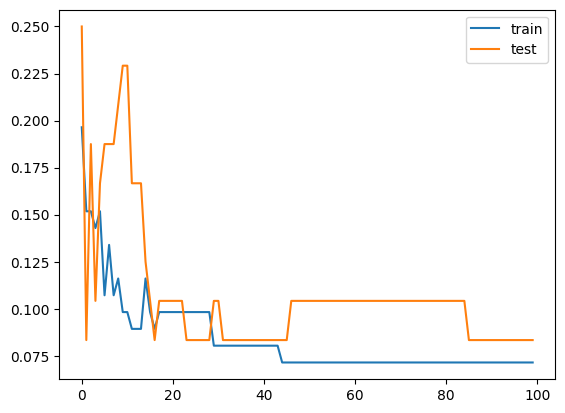

In [34]:
plot_metric(model,eval_metric)

In [35]:
y_preds = model.predict(X_train)

cr = classification_report(y_train, y_preds)
print(cr)

y_preds = model.predict(X_test)

cr = classification_report(y_test, y_preds)
print(cr)

              precision    recall  f1-score   support

        Alto       0.89      0.97      0.93        32
       Baixo       0.93      0.93      0.93        45
       Médio       0.97      0.89      0.93        35

    accuracy                           0.93       112
   macro avg       0.93      0.93      0.93       112
weighted avg       0.93      0.93      0.93       112

              precision    recall  f1-score   support

        Alto       1.00      0.94      0.97        16
       Baixo       0.85      1.00      0.92        17
       Médio       0.92      0.80      0.86        15

    accuracy                           0.92        48
   macro avg       0.92      0.91      0.91        48
weighted avg       0.92      0.92      0.92        48



Features de maior importancia ao modelo

In [36]:
from operator import itemgetter
importances=[]
for element in sorted(
    list(
        zip(
            model.feature_importances_, X_train.columns
        )
    ),
    key=itemgetter(0),
):
    importances.append(element)
importances

[(0.0, 'popDe10a14'),
 (0.028203046, 'popAte9'),
 (0.036425527, 'domiciliosE'),
 (0.036655527, 'domiciliosD'),
 (0.039984833, 'domiciliosC2'),
 (0.040283673, 'popDe25a34'),
 (0.04118149, 'rendaMedia'),
 (0.05071579, 'popDe15a19'),
 (0.051711507, 'domiciliosC1'),
 (0.052092142, 'domiciliosA1'),
 (0.054709893, 'popDe35a49'),
 (0.06983957, 'população'),
 (0.07002102, 'domiciliosB2'),
 (0.071435034, 'domiciliosA2'),
 (0.08406548, 'popDe20a24'),
 (0.08732485, 'popDe50a59'),
 (0.09095586, 'popMaisDe60'),
 (0.09439472, 'domiciliosB1')]

In [37]:
len(test_x)

293

In [38]:
potencial = model.predict(test_x)
len(potencial)

293

In [39]:
len(potencial),len(results_reg['predicao'])

(293, 293)

In [40]:
sp_df['potencial']=potencial
sp_df['faturamento']=results_reg['predicao']

In [41]:
sp_df.to_csv('/content/Dados/sp_df_predicao.csv',index=False)

#### Explicabilidade Shapley values

In [42]:
import shap
# print the JS visualization code to the notebook
shap.initjs()

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [43]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

In [44]:
#predicao real
y_train[0]

'Baixo'

In [45]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_train.iloc[0,:])

In [46]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], X_train.iloc[:1000,:])

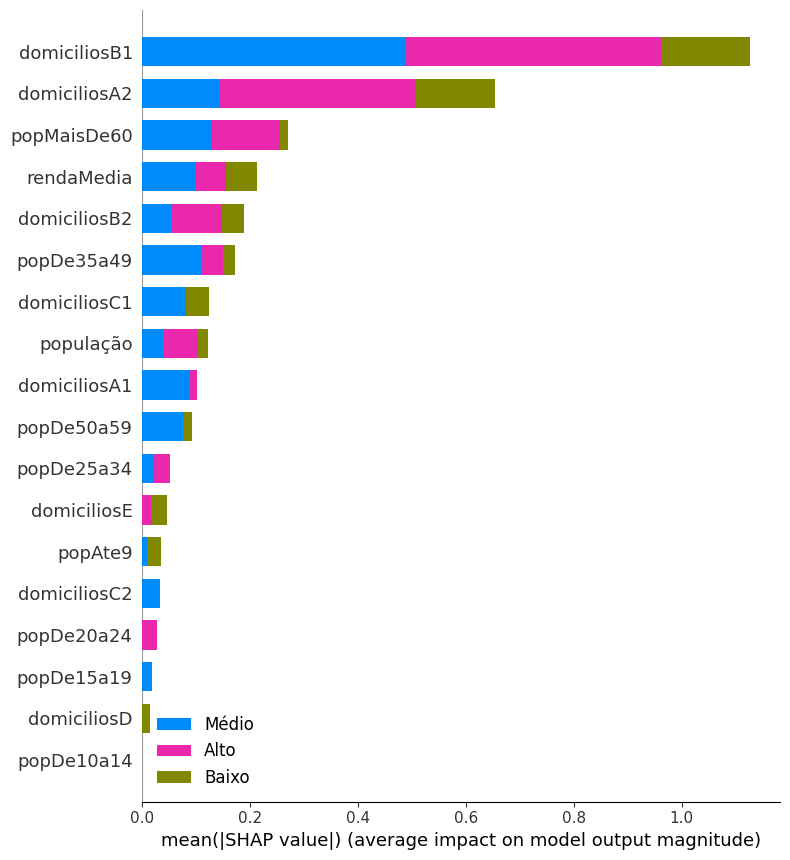

In [47]:
shap.summary_plot(shap_values, X_train,class_names=['Alto','Médio','Baixo'])

# Análise Informações Exógenas


Aqui são feitos alguns experimentos utilizando informações exógenas. Informações como idh dos bairros do Rio e artigos da Wikipedia são coletados e utilizados para análise e como adição nas etapas de classificação

## Wikipedia

### Extracao

In [48]:
import pandas as pd
rj_df=pd.read_csv('/content/Dados/rj_df.csv')
sp_df=pd.read_csv('/content/Dados/sp_df.csv')
sp_df.shape,rj_df.shape

((293, 24), (160, 24))

In [49]:
import json
with open('/content/Dados/rio-de-janeiro/wiki_rj.json') as json_file:
    rio_wiki = json.load(json_file)

In [50]:
import string

articles=[]
for i in range(len(rj_df)):
  name=rj_df['nome'].iloc[i]
  c=0
  for j in range(len(rio_wiki[0]['output'])):
    n=rio_wiki[0]['output'][j]['input_value'][:-23]
    if name==n:
      s=str(rio_wiki[0]['output'][j]['output_value'])
      s = s.translate(str.maketrans('', '', """!"#$%&'()*+-/;<=>?@[\]^_`{|}~"""))
      articles.append(s)
      c+=1
  if c==0:
    articles.append(' ')
len(articles)

160

In [51]:
rj_df['articles']=articles
rj_df

,nome,codigo,cidade,estado,população,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,...,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,potencial,articles
0,Abolição,3.304557e+09,Rio de Janeiro,RJ,11676.0,1027.0,483.0,688.0,800.0,1675.0,...,715.0,1242.0,1093.0,758.0,92.0,304.0,2501.0,932515.0,Médio,
1,Acari,3.304557e+09,Rio de Janeiro,RJ,27564.0,5131.0,2188.0,2697.0,2630.0,4810.0,...,82.0,506.0,2040.0,2490.0,827.0,2506.0,931.0,588833.0,Baixo,Description: Acari é um bairro de classe baixa...
2,Água Santa,3.304557e+09,Rio de Janeiro,RJ,9003.0,883.0,399.0,597.0,762.0,1755.0,...,404.0,652.0,644.0,522.0,77.0,254.0,2391.0,874200.0,Baixo,Description: Água Santa é um bairro predominan...
3,Alto Da Boa Vista,3.304557e+09,Rio de Janeiro,RJ,9606.0,1072.0,538.0,660.0,685.0,1317.0,...,393.0,517.0,945.0,584.0,137.0,286.0,3727.0,912226.0,Médio,Description: Alto da Boa Vista é um bairro da ...
4,Anchieta,3.304557e+09,Rio de Janeiro,RJ,57222.0,7677.0,3774.0,4892.0,4600.0,8660.0,...,1089.0,2821.0,5110.0,5422.0,1073.0,3261.0,1380.0,553020.0,Médio,Description: Anchieta é um bairro da Zona Nort...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,Vila Kosmos,3.304557e+09,Rio de Janeiro,RJ,18791.0,1802.0,921.0,1442.0,1462.0,2500.0,...,774.0,1363.0,1923.0,1379.0,190.0,405.0,2316.0,901446.0,Médio,Description: Cosmos é um bairro da Zona Oeste ...
156,Vila Militar,3.304557e+09,Rio de Janeiro,RJ,13556.0,1888.0,787.0,1042.0,982.0,2542.0,...,714.0,828.0,1051.0,1012.0,116.0,465.0,2416.0,849731.0,Médio,Description: Vila Militar é um bairro planejad...
157,Vila Valqueire,3.304557e+09,Rio de Janeiro,RJ,33190.0,3166.0,1619.0,2255.0,2326.0,4752.0,...,2866.0,2241.0,2982.0,1200.0,360.0,772.0,3189.0,1127042.0,Alto,Description: Vila Valqueire é um bairro de cla...
158,Vista Alegre,3.304557e+09,Rio de Janeiro,RJ,8867.0,724.0,387.0,580.0,565.0,1205.0,...,556.0,836.0,940.0,484.0,75.0,214.0,2418.0,921875.0,Baixo,Description: Vista Alegre é um bairro da Zona ...


In [52]:
# rio_wiki[0]['output'][0]

### Analise

#### Wordcloud

In [55]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [56]:
from nltk.corpus import stopwords
import nltk
import unidecode
nltk.download('stopwords')
nltk.download('punkt')

def has_letter(s):
    l=False
    for c in s:
        if c.isalpha():
            l=True
            continue
        else:
            if c in '!@#$%*,.;:?=+-_\/`´^~(){}[]':
                return False
    if l==True:
        return True
    return False

def preprocess(line):
    line = unidecode.unidecode(line.lower())
    words =line.strip().split()
    line = [w for w in words if w not in stop_words and len(w)>2  and has_letter(w)]
    return line

stop_words = [
              unidecode.unidecode(word) 
              for word in stopwords.words('portuguese') 
]
stop_words.extend(['bairro','bairros','avenida','estrada','rua','municipio','rio','janeiro','sendo','ainda','nome','onde',
                   'possui','estado','alem','hoje','linha','regiao','ano','atual','area','centro','praca','outro','cidade',
                   'vila','grande','anos','ruas','estacao','parte','outros','casa','maior'])
stop_words={s:1 for s in stop_words}

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [57]:
def wordcloud_plot(texts):
  text =' '.join(' '.join(preprocess(t)) for t in texts)

  # Create and generate a word cloud image:
  wc = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
  print(wc)

  # Display the generated image:
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.show()

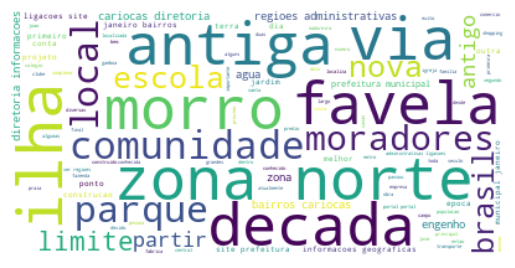

In [58]:
texts=rj_df[rj_df['potencial']=='Baixo']['articles'].values
wordcloud_plot(texts)

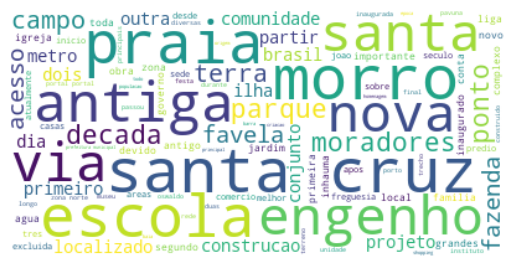

In [59]:
texts=rj_df[rj_df['potencial']=='Médio']['articles'].values
wordcloud_plot(texts)

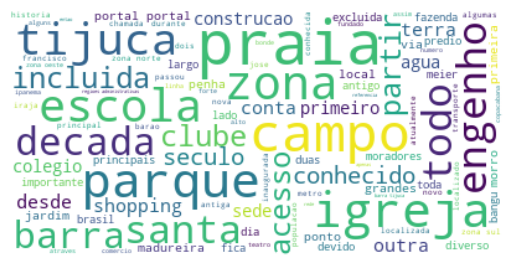

In [60]:
texts=rj_df[rj_df['potencial']=='Alto']['articles'].values
wordcloud_plot(texts)

## IDH

In [61]:
import pandas as pd

In [62]:
rio_idh_df = (
    pd.read_excel(
    "/content/Dados/rio-de-janeiro/idh_rio.xls", 
    "2000", 
    skiprows=6, 
    index_col=0, 
    nrows=127)
    .drop(columns=["Unnamed: 5", "Unnamed: 7"])
    .dropna()
    .assign(
        bairro= lambda d: d["Bairro ou grupo de bairros"].str.split(",")
    )
    .explode("bairro")
)

In [63]:
rio_idh_df["bairro"] = rio_idh_df["bairro"].str.strip().replace(
    "Parque Colúmbia", "Parque Columbia"
).replace(
    "Vila Cosmos", "Vila Kosmos"
).replace(
    "Freguesia", "Freguesia (Ilha do Governador)"
)

rio_idh_df

,Bairro ou grupo de bairros,Esperança de vida ao nascer (em anos),Taxa de alfabetização de adultos (%),Taxa bruta de frequência escolar (%),Renda per capita (em R$ de 2000),Índice de Longevidade (IDH-L),Índice de Educação (IDH-E),Índice de Renda (IDH-R),Índice de Desenvolvimento Humano Municipal (IDH),bairro
Ordem segundo o IDH,,,,,,,,,,
1.0,Gávea,80.448350,98.075063,118.128999,2139.559275,0.924139,0.987167,1.000000,0.970435,Gávea
2.0,Leblon,79.467946,99.010431,105.179624,2441.279121,0.907799,0.993403,1.000000,0.967067,Leblon
3.0,Jardim Guanabara,80.466082,98.915117,111.146968,1316.862722,0.924435,0.992767,0.971800,0.963001,Jardim Guanabara
4.0,Ipanema,78.675660,98.779013,107.980714,2465.445144,0.894594,0.991860,1.000000,0.962151,Ipanema
5.0,Lagoa,77.910525,99.464012,115.257230,2955.293718,0.881842,0.996427,1.000000,0.959423,Lagoa
...,...,...,...,...,...,...,...,...,...,...
123.0,Maré,66.578039,89.456081,68.758567,187.247695,0.692967,0.825569,0.646214,0.721584,Maré
124.0,"Acari, Parque Colúmbia",63.927183,91.679437,79.444257,174.122541,0.648786,0.876010,0.634084,0.719627,Acari
124.0,"Acari, Parque Colúmbia",63.927183,91.679437,79.444257,174.122541,0.648786,0.876010,0.634084,0.719627,Parque Columbia


In [64]:
rj_df=pd.read_csv('/content/Dados/rj_df.csv')

In [65]:
rj_df=rj_df.merge(rio_idh_df, left_on='nome', right_on='bairro')
rj_df

,nome,codigo,cidade,estado,população,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,...,Bairro ou grupo de bairros,Esperança de vida ao nascer (em anos),Taxa de alfabetização de adultos (%),Taxa bruta de frequência escolar (%),Renda per capita (em R$ de 2000),Índice de Longevidade (IDH-L),Índice de Educação (IDH-E),Índice de Renda (IDH-R),Índice de Desenvolvimento Humano Municipal (IDH),bairro
0,Abolição,3.304557e+09,Rio de Janeiro,RJ,11676.0,1027.0,483.0,688.0,800.0,1675.0,...,Abolição,73.284791,97.065606,95.693226,467.227900,0.804747,0.966081,0.798841,0.856556,Abolição
1,Acari,3.304557e+09,Rio de Janeiro,RJ,27564.0,5131.0,2188.0,2697.0,2630.0,4810.0,...,"Acari, Parque Colúmbia",63.927183,91.679437,79.444257,174.122541,0.648786,0.876010,0.634084,0.719627,Acari
2,Água Santa,3.304557e+09,Rio de Janeiro,RJ,9003.0,883.0,399.0,597.0,762.0,1755.0,...,"Água Santa, Encantado",76.205574,97.483077,95.648586,496.656375,0.853426,0.968716,0.809037,0.877060,Água Santa
3,Anchieta,3.304557e+09,Rio de Janeiro,RJ,57222.0,7677.0,3774.0,4892.0,4600.0,8660.0,...,Anchieta,68.898019,95.647500,84.753548,278.180311,0.731634,0.920162,0.712287,0.788027,Anchieta
4,Andaraí,3.304557e+09,Rio de Janeiro,RJ,40476.0,3528.0,1703.0,2564.0,2753.0,5993.0,...,Andaraí,74.989346,98.054083,103.850991,897.074233,0.833156,0.987027,0.907725,0.909303,Andaraí
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,Vila Kosmos,3.304557e+09,Rio de Janeiro,RJ,18791.0,1802.0,921.0,1442.0,1462.0,2500.0,...,Vila Cosmos,77.203408,97.579884,89.459722,498.823426,0.870057,0.948732,0.809764,0.876184,Vila Kosmos
133,Vila Militar,3.304557e+09,Rio de Janeiro,RJ,13556.0,1888.0,787.0,1042.0,982.0,2542.0,...,"Deodoro, Vila Militar, Campo dos Afonsos, Jard...",73.587915,97.750054,93.264770,462.129648,0.809799,0.962550,0.797010,0.856453,Vila Militar
134,Vila Valqueire,3.304557e+09,Rio de Janeiro,RJ,33190.0,3166.0,1619.0,2255.0,2326.0,4752.0,...,"Campinho, Vila Valqueire",77.473652,97.857564,96.690569,684.938812,0.874561,0.974686,0.862689,0.903979,Vila Valqueire
135,Vista Alegre,3.304557e+09,Rio de Janeiro,RJ,8867.0,724.0,387.0,580.0,565.0,1205.0,...,"Vista Alegre, Irajá",62.813200,98.081858,92.989333,473.393562,0.630220,0.963843,0.801030,0.798364,Vista Alegre


In [66]:
rj_df=rj_df.drop(columns=['Bairro ou grupo de bairros','bairro'])

In [67]:
train_x=rj_df
train_x['rendaMedia']=pd.to_numeric(train_x["rendaMedia"])
train_y=train_x['potencial'].values
train_x=train_x.drop(columns=['nome','cidade','estado','potencial','faturamento'])
train_x.shape

(137, 27)

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    train_x,train_y, test_size=0.30, random_state=42)

In [69]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier


In [70]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import (precision_score, recall_score, f1_score,
    roc_auc_score)

pipe = Pipeline(
    steps=[
        ("XGB", XGBClassifier())
  ]
)

parameters = {
    "XGB__objective": ["multi:softprob","multi:softmax"],
    "XGB__learning_rate": [0.1,0.01],
    "XGB__booster": ["gbtree","gblinear"],
    "XGB__max_depth": [3,5,7],
    "XGB__min_child_weight": [3,5,7],
    "XGB__colsample_bytree": [0.25],
    "XGB__n_estimators": [30,50,100],
    "XGB__reg_alpha": [0.2,0.5],
    "XGB__reg_lambda": [2,5,7],
    "XGB__gamma": [3,5,7],
    "XGB__random_state": [123],
    # "XGB__eval_metric": [f1_score],
    "XGB__num_class": [3],
    # "XGB__eval_set" : [(X_res, y_train_num), (X_test,y_test_num)]

}

In [71]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

pipe.fit(X_train, y_train)
search = GridSearchCV(pipe, parameters, cv=3, n_jobs=-1, verbose=1)
search.fit(X_train, y_train)

Fitting 3 folds for each of 3888 candidates, totalling 11664 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('XGB',
                                        XGBClassifier(objective='multi:softprob'))]),
             n_jobs=-1,
             param_grid={'XGB__booster': ['gbtree', 'gblinear'],
                         'XGB__colsample_bytree': [0.25],
                         'XGB__gamma': [3, 5, 7],
                         'XGB__learning_rate': [0.1, 0.01],
                         'XGB__max_depth': [3, 5, 7],
                         'XGB__min_child_weight': [3, 5, 7],
                         'XGB__n_estimators': [30, 50, 100],
                         'XGB__num_class': [3],
                         'XGB__objective': ['multi:softprob', 'multi:softmax'],
                         'XGB__random_state': [123],
                         'XGB__reg_alpha': [0.2, 0.5],
                         'XGB__reg_lambda': [2, 5, 7]},
             verbose=1)

In [72]:
from sklearn.metrics import classification_report
print("XGBoost\n")
print("Best parameter (CV score=%0.3f): {}\n".format(search.best_score_))
print(search.best_params_)

print("Best parameters: " + str(search.best_params_))

y_preds = search.best_estimator_.predict(X_train)

cr = classification_report(y_train, y_preds)
print(cr)

y_preds = search.best_estimator_.predict(X_test)

cr = classification_report(y_test, y_preds)
print(cr)

XGBoost

Best parameter (CV score=%0.3f): 0.8424059139784946

{'XGB__booster': 'gblinear', 'XGB__colsample_bytree': 0.25, 'XGB__gamma': 3, 'XGB__learning_rate': 0.1, 'XGB__max_depth': 3, 'XGB__min_child_weight': 3, 'XGB__n_estimators': 100, 'XGB__num_class': 3, 'XGB__objective': 'multi:softprob', 'XGB__random_state': 123, 'XGB__reg_alpha': 0.2, 'XGB__reg_lambda': 2}
Best parameters: {'XGB__booster': 'gblinear', 'XGB__colsample_bytree': 0.25, 'XGB__gamma': 3, 'XGB__learning_rate': 0.1, 'XGB__max_depth': 3, 'XGB__min_child_weight': 3, 'XGB__n_estimators': 100, 'XGB__num_class': 3, 'XGB__objective': 'multi:softprob', 'XGB__random_state': 123, 'XGB__reg_alpha': 0.2, 'XGB__reg_lambda': 2}
              precision    recall  f1-score   support

        Alto       0.94      0.94      0.94        31
       Baixo       0.86      0.95      0.90        38
       Médio       0.91      0.77      0.83        26

    accuracy                           0.89        95
   macro avg       0.90      0.88  

# Experimento: Abordagem Não Supervisionada(Redução de Dimensionalidade e Clusterizacao)

In [73]:
import plotnine as p9
import umap

### Umap

In [74]:
import pandas as pd
df=pd.read_csv('/content/Dados/rio-de-janeiro/rio_geo.csv')
df.fillna(0,inplace=True)
df.head()

,regiao_adm,regiao_planejamento,geometry,nome,cidade,estado,população,popAte9,popDe10a14,popDe15a19,...,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,potencial
0,PAQUETA,Centro,MULTIPOLYGON (((-43.10571371961273 -22.7488900...,Paquetá,Rio de Janeiro,RJ,3270.0,369.0,158.0,229.0,...,10.0,115.0,244.0,380.0,329.0,65.0,108.0,1696.0,854818.0,Baixo
1,ILHA DO GOVERNADOR,Ilha do Governador,MULTIPOLYGON (((-43.17174027912554 -22.7766241...,Freguesia (Ilha Do Governador),Rio de Janeiro,RJ,19984.0,2311.0,1124.0,1497.0,...,200.0,931.0,1243.0,1864.0,1815.0,304.0,623.0,2125.0,796321.0,Médio
2,ILHA DO GOVERNADOR,Ilha do Governador,MULTIPOLYGON (((-43.18919378883584 -22.7831924...,Bancários,Rio de Janeiro,RJ,12864.0,1532.0,670.0,963.0,...,82.0,491.0,750.0,1313.0,1177.0,172.0,352.0,1962.0,808554.0,Baixo
3,ILHA DO GOVERNADOR,Ilha do Governador,MULTIPOLYGON (((-43.22808465065143 -22.7837488...,Galeão,Rio de Janeiro,RJ,23620.0,3638.0,1724.0,2411.0,...,85.0,767.0,1083.0,2007.0,2005.0,348.0,979.0,1740.0,684686.0,Médio
4,ILHA DO GOVERNADOR,Ilha do Governador,POLYGON ((-43.1804360604279 -22.79940948244976...,Tauá,Rio de Janeiro,RJ,30403.0,4008.0,1783.0,2398.0,...,138.0,1081.0,1651.0,2673.0,2467.0,436.0,1962.0,1704.0,752629.0,Médio


In [75]:
regiao_adm =df['regiao_adm'].values
regiao_planejamento = df['regiao_planejamento'].values
nomes = df['nome'].values
potencial = df['potencial'].values

In [76]:
df=df.drop(columns=['nome','geometry','cidade','estado','faturamento','potencial'])

In [77]:
# use Umap to do embedding then cluster on that
def plot_2d_umap(df, intersection=False):

  numerical = df.select_dtypes(exclude='object')

  for c in numerical.columns:
      numerical[c] = (numerical[c] - numerical[c].mean())/numerical[c].std(ddof=0)
      
  ##preprocessing categorical
  categorical = df.select_dtypes(include='object')
  categorical = pd.get_dummies(categorical)

  #Percentage of columns which are categorical is used as weight parameter in embeddings later
  categorical_weight = len(df.select_dtypes(include='object').columns) / df.shape[1]

  #Embedding numerical & categorical
  fit1 = umap.UMAP(random_state=12).fit(numerical)
  fit2 = umap.UMAP(metric='dice', n_neighbors=250).fit(categorical)

  numeric_embedding = fit1.embedding_
  numeric = pd.DataFrame(
                         {'x': numeric_embedding[:,0],
                         'y':  numeric_embedding[:,1],
                        })
  

  categorical_embedding = fit2.embedding_
  categorical = pd.DataFrame(
                         {'x': categorical_embedding[:,0],
                         'y':  categorical_embedding[:,1],
                        })


  # intersection will resemble the numerical embedding more.
  if intersection:
    embedding = fit1 * fit2

  # union will resemble the categorical embedding more.
  else:
    embedding = fit1 + fit2

  umap_embedding = embedding.embedding_


  results = pd.DataFrame(
                        {'x': umap_embedding[:,0],
                         'y':  umap_embedding[:,1],
                        })
  


  numeric = (p9.ggplot(numeric, p9.aes(x='x', y='y'))
              + p9.geom_point(alpha=0.6)
              + p9.ggtitle('Numeric Embedding'))
  
  categorical = (p9.ggplot(categorical, p9.aes(x='x', y='y'))
              + p9.geom_point(alpha=0.6)
              + p9.ggtitle('Categorical Embedding'))
  
  combined = (p9.ggplot(results, p9.aes(x='x', y='y'))
              + p9.geom_point(alpha=0.6)
              + p9.ggtitle('Combined Embedding'))
  
  return numeric, categorical, combined, umap_embedding

numeric, categorical, combined, embedding_ =  plot_2d_umap(df, intersection=True)

/tmp/ipykernel_143/1291774223.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
/opt/conda/lib/python3.10/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1


In [78]:
from sklearn.cluster import KMeans

df['x'] = embedding_[:,0]
df['y'] = embedding_[:,1]

df['label'] = nomes


UMAP_clusterer = KMeans(n_clusters=5, init='k-means++',
                        verbose=0, random_state=123,
                        algorithm='auto').fit(embedding_)

df["preds"] = UMAP_clusterer.labels_

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1318: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.


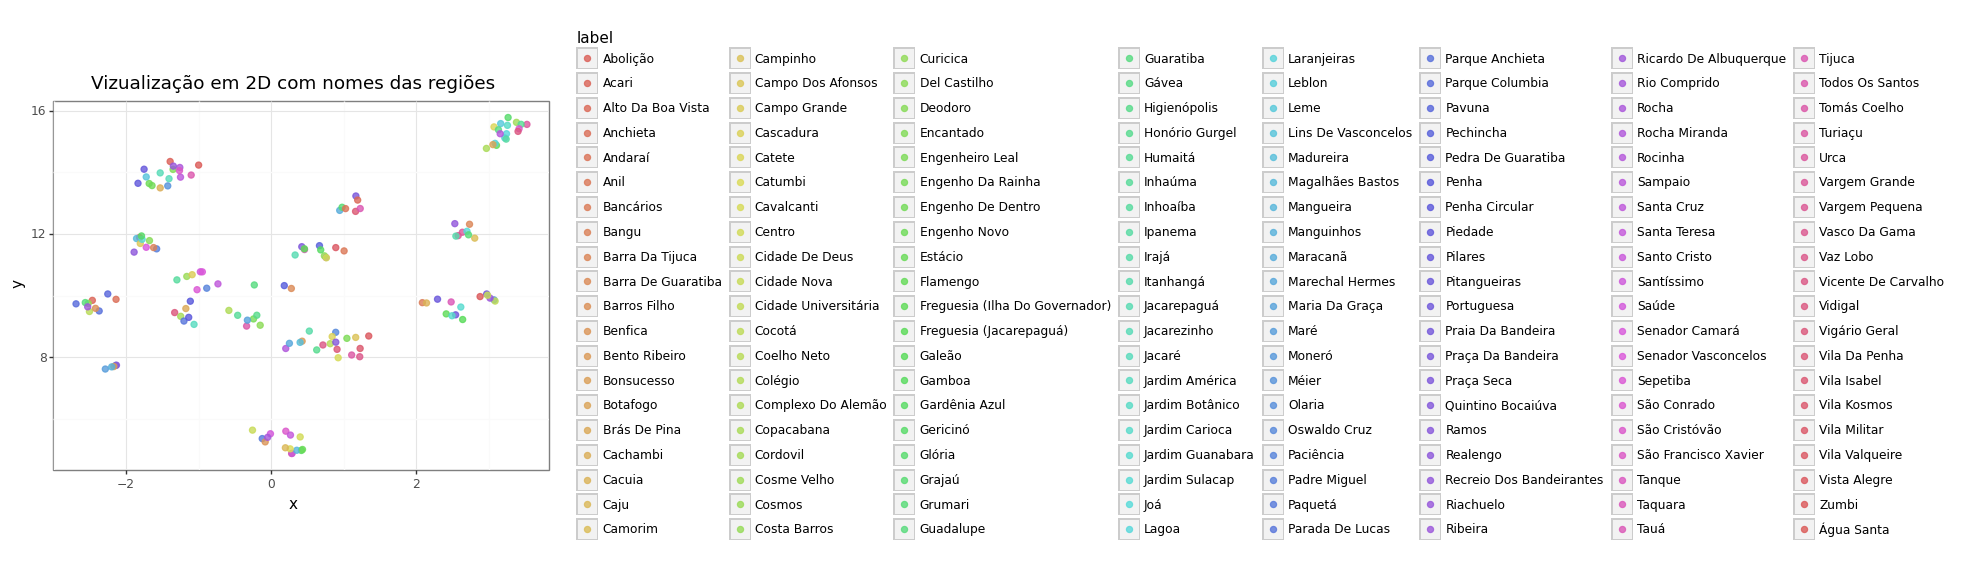

<ggplot: (8756918445369)>

In [79]:
#com o nome dos bairros pintados
df['label']=nomes
p = (p9.ggplot(df, p9.aes(x='x', y='y', fill='label', color='label'))
      + p9.geom_point(alpha=0.8, size=2)
      + p9.ggtitle('Vizualização em 2D com nomes das regiões')
      + p9.theme_bw())
p

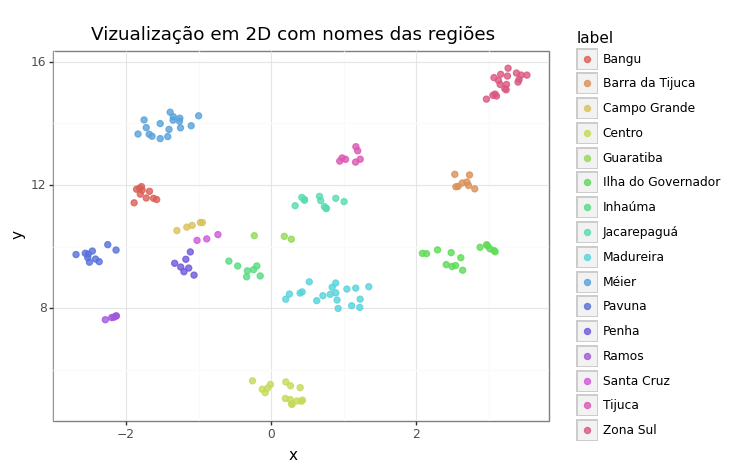

<ggplot: (8756918291408)>

In [80]:
#com o nome das regioes planejamento pintadas
df['label']=regiao_planejamento
p = (p9.ggplot(df, p9.aes(x='x', y='y', fill='label', color='label'))
      + p9.geom_point(alpha=0.8, size=2)
      + p9.ggtitle('Vizualização em 2D com nomes das regiões')
      + p9.theme_bw())
p

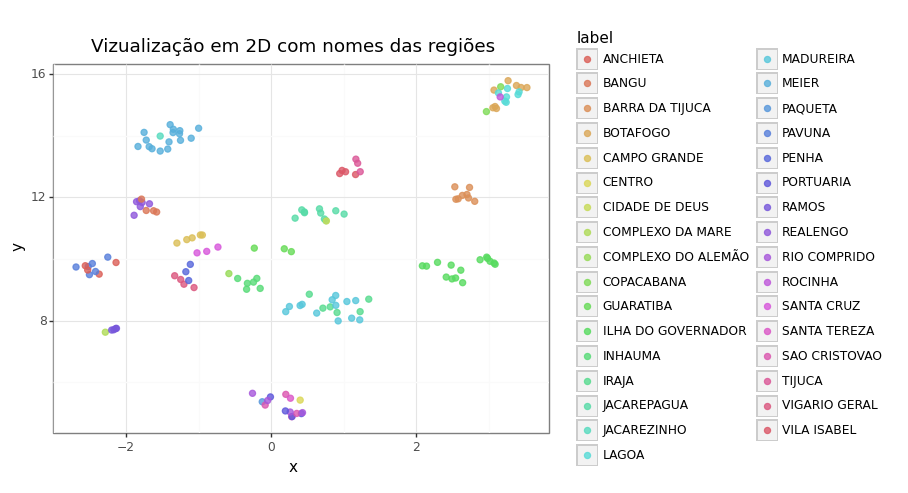

<ggplot: (8756917986154)>

In [81]:
#com o nome das regioes administrativas pintadas
df['label']=regiao_adm
p = (p9.ggplot(df, p9.aes(x='x', y='y', fill='label', color='label'))
      + p9.geom_point(alpha=0.8, size=2)
      + p9.ggtitle('Vizualização em 2D com nomes das regiões')
      + p9.theme_bw())
p

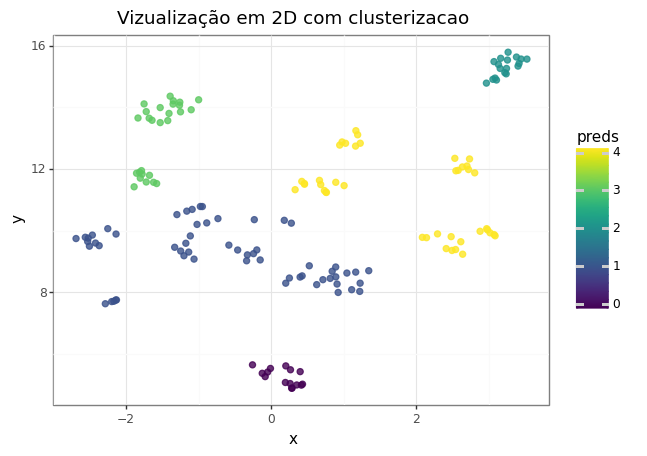

<ggplot: (8756918160808)>

In [82]:
p = (p9.ggplot(df, p9.aes(x='x', y='y', fill='preds', color='preds'))
      + p9.geom_point(alpha=0.8, size=2)
      + p9.ggtitle('Vizualização em 2D com clusterizacao')
      + p9.theme_bw())
p

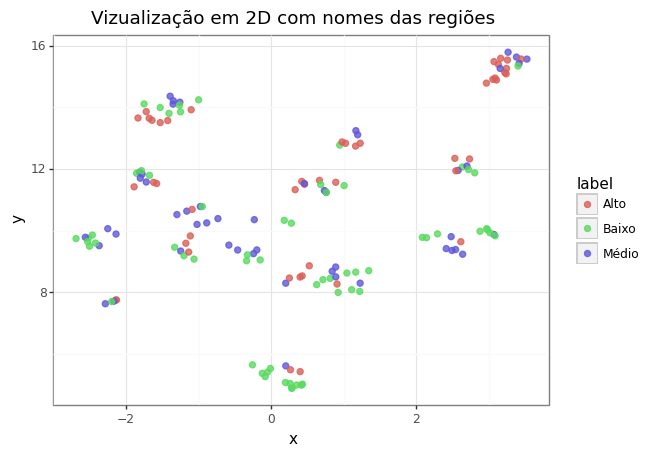

<ggplot: (8756917825134)>

In [83]:
#com o nome das regioes em potencial pintadas
df['label']=potencial
p = (p9.ggplot(df, p9.aes(x='x', y='y', fill='label', color='label'))
      + p9.geom_point(alpha=0.8, size=2)
      + p9.ggtitle('Vizualização em 2D com nomes das regiões')
      + p9.theme_bw())
p

## Clusterizacao Rio-São Paulo

Mantemos somente as variaveis originais(nao adicionamos zonas administrativas, ja que eles não se traduzem igualmente em são Paulo)


In [84]:
import pandas as pd
df=pd.read_csv('/content/Dados/DadosDesafioCientista.csv')
df.head()

,codigo,nome,cidade,estado,população,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,...,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,potencial
0,3304557060,Abolição,Rio de Janeiro,RJ,11676,1027,483,688,800,1675,...,145,715,1242,1093,758,92,304,2501,932515.0,Médio
1,3304557138,Acari,Rio de Janeiro,RJ,27564,5131,2188,2697,2630,4810,...,0,82,506,2040,2490,827,2506,931,588833.0,Baixo
2,3304557057,Água Santa,Rio de Janeiro,RJ,9003,883,399,597,762,1755,...,96,404,652,644,522,77,254,2391,874200.0,Baixo
3,3304557031,Alto Da Boa Vista,Rio de Janeiro,RJ,9606,1072,538,660,685,1317,...,178,393,517,945,584,137,286,3727,912226.0,Médio
4,3304557125,Anchieta,Rio de Janeiro,RJ,57222,7677,3774,4892,4600,8660,...,0,1089,2821,5110,5422,1073,3261,1380,553020.0,Médio


In [85]:
nomes = df['nome'].values
cidades=df['cidade'].values

In [86]:
df=df.drop(columns=['nome','cidade','codigo','estado','faturamento','potencial'])

In [87]:
# use Umap to do embedding then cluster on that
def plot_2d_umap(df, intersection=False):

  numerical = df.select_dtypes(exclude='object')

  for c in numerical.columns:
      numerical[c] = (numerical[c] - numerical[c].mean())/numerical[c].std(ddof=0)
      
  ##preprocessing categorical
  categorical = df.select_dtypes(include='object')
  categorical = pd.get_dummies(categorical)

  #Percentage of columns which are categorical is used as weight parameter in embeddings later
  categorical_weight = len(df.select_dtypes(include='object').columns) / df.shape[1]

  #Embedding numerical & categorical
  fit1 = umap.UMAP(random_state=12).fit(numerical)
  fit2 = umap.UMAP(metric='dice', n_neighbors=250).fit(categorical)

  numeric_embedding = fit1.embedding_
  numeric = pd.DataFrame(
                         {'x': numeric_embedding[:,0],
                         'y':  numeric_embedding[:,1],
                        })
  

  categorical_embedding = fit2.embedding_
  categorical = pd.DataFrame(
                         {'x': categorical_embedding[:,0],
                         'y':  categorical_embedding[:,1],
                        })


  # intersection will resemble the numerical embedding more.
  if intersection:
    embedding = fit1 * fit2

  # union will resemble the categorical embedding more.
  else:
    embedding = fit1 + fit2

  umap_embedding = embedding.embedding_


  results = pd.DataFrame(
                        {'x': umap_embedding[:,0],
                         'y':  umap_embedding[:,1],
                        })
  


  numeric = (p9.ggplot(numeric, p9.aes(x='x', y='y'))
              + p9.geom_point(alpha=0.6)
              + p9.ggtitle('Numeric Embedding'))
  
  categorical = (p9.ggplot(categorical, p9.aes(x='x', y='y'))
              + p9.geom_point(alpha=0.6)
              + p9.ggtitle('Categorical Embedding'))
  
  combined = (p9.ggplot(results, p9.aes(x='x', y='y'))
              + p9.geom_point(alpha=0.6)
              + p9.ggtitle('Combined Embedding'))
  
  return numeric, categorical, combined, umap_embedding

numeric, categorical, combined, embedding_ =  plot_2d_umap(df, intersection=True)

/tmp/ipykernel_143/1291774223.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
/opt/conda/lib/python3.10/site-packages/umap/umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 207376 edges.
It has fully disconnected 388 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.


In [88]:
from sklearn.cluster import KMeans

df['x'] = embedding_[:,0]
df['y'] = embedding_[:,1]

df['label'] = nomes


UMAP_clusterer = KMeans(n_clusters=5, init='k-means++',
                        verbose=0, random_state=123,
                        algorithm='auto').fit(embedding_)

df["preds"] = UMAP_clusterer.labels_

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1318: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.


Resultado da clusterizacao no grafico abaixo. Ele une bairros do rio e são paulo que consideram serem mais similares. Uma análise minuciosa é necessária pra averiguar o que bairros próximos tem em comum.

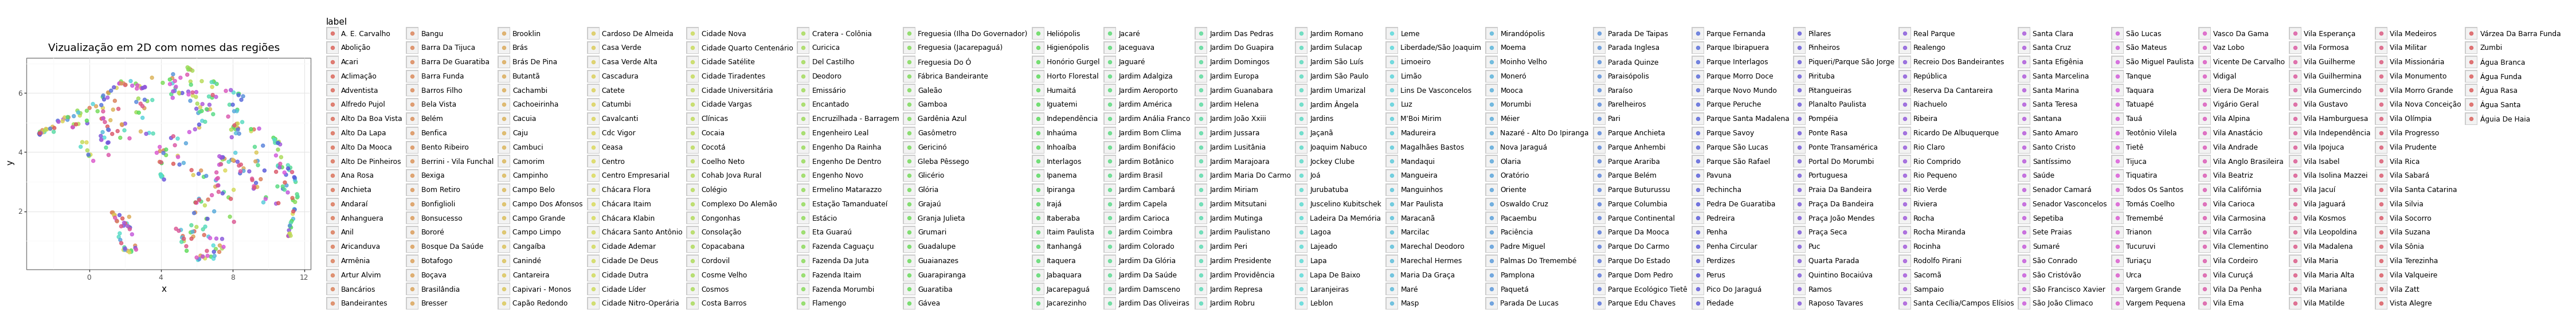

<ggplot: (8756917760760)>

In [89]:
#com o nome dos bairros pintados
df['label']=nomes
p = (p9.ggplot(df, p9.aes(x='x', y='y', fill='label', color='label'))
      + p9.geom_point(alpha=0.8, size=2)
      + p9.ggtitle('Vizualização em 2D com nomes das regiões')
      + p9.theme_bw())
p

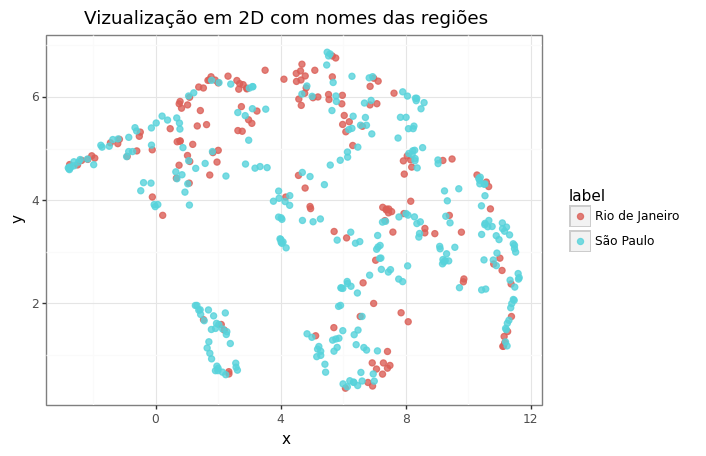

<ggplot: (8756919516935)>

In [90]:
#com o nome das cidades
df['label']=cidades
p = (p9.ggplot(df, p9.aes(x='x', y='y', fill='label', color='label'))
      + p9.geom_point(alpha=0.8, size=2)
      + p9.ggtitle('Vizualização em 2D com nomes das regiões')
      + p9.theme_bw())
p

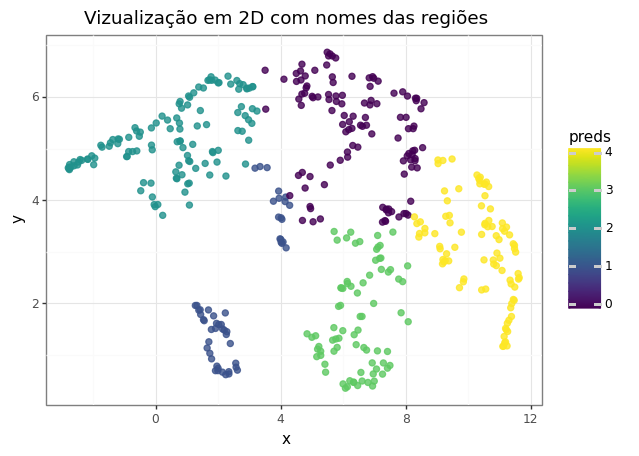

<ggplot: (8756918379539)>

In [91]:
#com os clusters
p = (p9.ggplot(df, p9.aes(x='x', y='y', fill='preds', color='preds'))
      + p9.geom_point(alpha=0.8, size=2)
      + p9.ggtitle('Vizualização em 2D com nomes das regiões')
      + p9.theme_bw())
p